In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.cross_validation as cv
import sklearn.grid_search as gs
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
%matplotlib inline


import scipy.stats as stats
from IPython.core.pylabtools import figsize

from mpl_toolkits.mplot3d import Axes3D

## Bayesian Inference : Market Condition 

### Discrete Example

We classify market condtion into 3 cases: A, B and C.  We also use numrtical notation: 1, 2 ,3 to denote A, B, C, repectively.  Suppose we know there is 10% chance for A, 60 for B and 30% chance for C.  We can think of this probability distribution of market condition:

([<matplotlib.axis.YTick at 0x114493b90>,
 <a list of 3 Text yticklabel objects>)

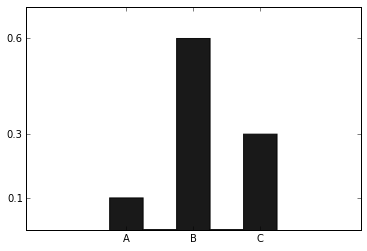

In [20]:
conds = [1, 2,2,2,2,2,2, 3,3,3]
plt.hist(conds, bins=5, color="k", histtype="stepfilled", alpha=0.9)
plt.xlim([0,4])
plt.ylim([0,7])
plt.xticks([1.2, 2.0 ,2.8], ['A','B','C'])
plt.yticks([1.0, 6.0, 3.0], [0.1,0.6,0.3])

Now we test an algorithm TA and we know that TA has 30% chance of success when market condition is in A, 50% for B and 80% for C.  In conditional probability notation we write:

$$ P(S \mid A) = 0.3 , \ P(S \mid B) = 0.5 , \   P(S \mid C) =  0.8 $$

So probability of success is:
 $$P(S) = P(S \mid A)P(A)+P(S \mid B)P(B) + P(S \mid C) P(C) = 0.3 \times 0.1 + 0.5 \times 0.6+0.8 \times 0.3=0.57 $$
 
By Bayes Theorem:
$$ P(A \mid S) = \frac{P(S \mid A) P(A)} {P(S)} $$
For example, we can find the probabilty that market condition is A when TA was successful:
$$ P(A \mid S) = \frac{ 0.3 \times 0.1}{0.57} $$

### Generalization

Next we want to generalize: classification of market condition is not clear cut like A,B,C.  That is, we want a gradation of market condition. What we want is to describe market condition in terms of (continuous) probability distribution. For example:   

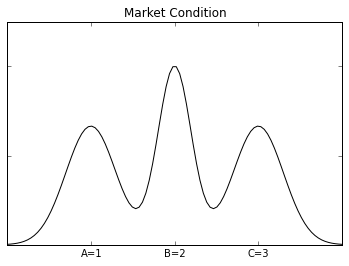

In [45]:
m_conds = np.linspace(0,4,100) #gradual market conditions

cond_dist = stats.norm(1.0, 0.3).pdf(m_conds) + stats.norm(2.0,0.2).pdf(m_conds)+stats.norm(3.0,0.3).pdf(m_conds)

plt.plot(m_conds, cond_dist, color='k')
plt.xlim([0,4])
plt.ylim([0,2.5])
plt.xticks([1.0, 2.0 ,3.0], ['A=1','B=2','C=3'])
plt.yticks([1.0, 2.0 ], ['',''])
plt.title('Market Condition')

So how do we know this curve we made up is a probability distribution?  In previous discrete example we had
$$ P(A) +P(B)+P(C) = 0.1+ 0.6 + 0.3 = 1.0 $$

In this continuous case we have to make sure this curve integrate to 1.  

Let $$ \text{market condition} = MC \in [0,4] $$
$$ dist(MC) = \text{probabity that market condition is} \ MC $$
Then we must have:
$$ \int_{0}^{4} dist(MC)\ d \mu $$
(Here $d\mu$ is called probability measure.)

In discrete case, if we can have numerous market conditions, say $\{ A_1, A_2, \dots , A_m\}$

Then probability chart should add up to 1:
$$ \sum_{i=1}^{m} P(A_i) = 1 $$
Indeed, the integral is limiting version of $\sum$ notation of discrete case.

#### So how about probabilities of success (S) and failure (F)?

We numerate by setting $S (success) =10.0$ and $F (failure) =-10.0$

Then as before, we can use discrete distribution for TA (trading algorithm) such as $P(S)=0.8,\ P(F)=0.2$

But even better, we choose continuous gradation of successes and failures.  That is, we numerate S and F as interval $[-10, 10]$ and denote by variable SF

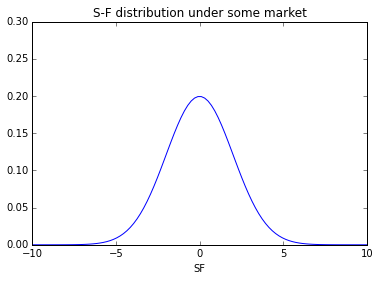

In [108]:
s_f = np.linspace(-10.0, 10.0, 100) # SF as interval
s_f_dist = stats.norm(0.0, 2.0).pdf(s_f) #Gaussian again, but not necessary.

plt.plot(s_f, s_f_dist)
plt.xlabel('SF')
plt.ylim([0,0.3])
plt.title('S-F distribution under some market')

We chose above Gaussian distribution for SF. Here we implicitly assumed some market condition, MC.  In bayesian terms, this is 'likelihood' denoted $P(SF \mid MC)$  

Recall that we chose for market conditions: $MC \in [0,4]$

For this example, we assume that SF distribution is Gaussian with different volatility ranging from 0.5 to 4.5
Market is most volatile (4.5) when market condition is 0 or 4.  And when market condition is 2.0, volatility is 0.5


In [88]:
vol = 0.5+(m_conds-2.0)**2 

print np.max(vol)

4.5


### Bayes Theorem (General Version)

Only change is finding $P(SF)$.  In discrete case, we had sum. In general we have integral.  Note that assuming we can write success and failure as some function of market condition, $SF(MC)$, we write: 
$$ P(MC \mid SF) = \frac{P(SF \mid MC) P(MC)} {P(SF)} = \frac{P(SF \mid MC) P(MC)}{\int P(SF(mc))\ d\mu}  $$

### What's ahead

We will eventually want to find Posterior $P(MC \mid SF)$, improved information from data.  MCMC is a promising tool.

Prior, $P(MC)$ should usually come from data or experience, similarly for likelihood $P(SF \mid MC)$. 

Of course, we can change the setup and switch the roles of SF and MC.  Typical workflow is 
- Estimate prior and likelihood
- MCMC simulate to get posterior.

#### Graphing $P(SF \mid MC)$

We graph $P(SF \mid MC)$ where $SF \in [-10, 10]$ and $MC \in [0,4]$

We choose $P(SF \mid MC)$ to be z coordinate. Then we can surface plot likelihood $P(SF \mid MC)$

(0.0, 1.0)

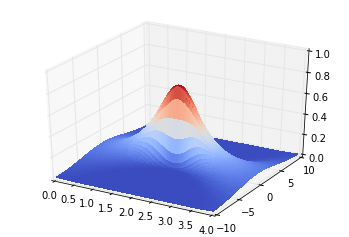

In [106]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

# MC, m_conds : x-axis [0, 4]
# SF, s_f: y-axis [-10, 10]
X, Y = np.meshgrid(m_conds, s_f)

Z = stats.norm(0.0, 0.5+(X-2.0)**2 ).pdf(Y)

ax.plot_surface(X, Y, Z,rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(0.0, 1.0)


#### Remark

I think bayesian inference and MCMC is conceptually and theoretically much more challenging than most ML, especially Deep Learning. I am still debating how much we should investigate MCMC since
- I heard MCMC is not widely used in quant finance perhaps because MCMC doesn't apply well to time series.
- bayesian inference is definitely useful for thought process.
- most ML techniques are based on bayesian.
- most ML algorithms seem much less challenging than MCMC, conceptually.

$\Alpha$